In [1]:
import dynamo as dyn


In [2]:
print(dyn.__version__)
dyn.get_all_dependencies_version()

0.95.2.dev270+704c423


package,anndata,colorcet,cvxopt,dynamo-release,hdbscan,loompy,matplotlib,numba,numdifftools,numpy,pandas,pynndescent,python-igraph,scikit-learn,scipy,seaborn,setuptools,statsmodels,tqdm,trimap,umap-learn
version,0.7.5,2.0.2,1.2.5,0.95.2,0.8.26,3.0.6,3.3.3,0.51.2,0.9.39,1.19.2,1.1.5,0.5.1,0.8.3,0.24.0,1.5.4,0.11.1,51.1.2.post20210112,0.12.1,4.56.0,1.0.14,0.4.6


In [3]:
# !pip install dynamo-release --upgrade --quiet

In [4]:


import dynamo as dyn

# set white background
dyn.configuration.set_figure_params(background='white')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gseapy.plot import barplot, dotplot

import warnings
warnings.filterwarnings('ignore')

In [36]:
plt.rc('legend',fontsize=32) # using a size in points
# plt.rc('legend',fontsize='medium') # using a named size

In [5]:
import numpy as np
import pandas as pd
import loompy
import hdbscan
import matplotlib.pyplot as plt
import numba
import mygene
import scipy
from gseapy.plot import barplot, dotplot
import warnings
warnings.filterwarnings('ignore')
# import pysal.lib
# import pysal.explore

dyn.configuration.set_figure_params('dynamo', background='white')

## Specify inputs and outputs

In [6]:
# specify inputs
main_folder = "/Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/2020Nova_Seq/RNA_velocity/"

full_RNA_folder = main_folder + "matrix_output_all_Tcell-cds/"
new_RNA_folder = main_folder + "matrix_output_new_Tcell-cds/"
df_cell_file = main_folder + "matrix_output_all_Tcell-cds/df_cell.tsv"

# specify outputs
output_folder = "/Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202101_output/"
output_folder_new = "/Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/"

# T cell umap coords
UMAP_coords_file_Tcell = "/Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202101_output/df_cell_5k_Tcell_7clust.csv"

# here, specify names of columns in UMAP_coords_file to use for UMAP cooridnates and clusters for plotting
umap1 = 'umap_Tcell_5k_aligned_1'
umap2 = 'umap_Tcell_5k_aligned_2'
clusters = 'Tcell_5k_aligned_7clust'

# specify cluster colors
cluster_colors =["#008B8B", "#08519C","#969696", "#cc6541", "#A50F15","#3F007D", "#ab62c0"]

# TFs of interest from scifate modules
TF_Tcell = ['JUNB', 'MYC', 'TBX21', 'IRF4', 'EGR1', 'NFATC1', 'BMYC', 'MXI1', 'STAT5A', 'NFAT5', 'ELK3', 'EOMES', 'REL', 'BHLHE40', 'STAT3', 'RUNX2', 'FOXO3', 'MXD4', 'BCL11B', 'CUX1', 'GTF2I', 'FOXO1', 'FLI1', 'STAT1', 'CHD2', 'ZEB1', 'FOXN3', 'TCF7', 'LEF1', 'ELF1', 'MYB', 'IKZF1', 'TCF12']

# Import full list of linked genes (only necessary if subsetting adata to only include cell cycle or T cell module genes )
gene_mod_filename = '/Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/2020Nova_Seq/gene_mod_Tcell_all.txt'
gene_file = open(gene_mod_filename, 'r')
data = gene_file.readlines()

gene_mod = []
with open(gene_mod_filename) as my_file:
   for line in my_file:
       gene_mod.append(line.rstrip())
        


In [7]:
# Import list of top 200 DEG between trajectories
DEG_filename = "/Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202101_output/trajectory_terms_top200q.txt"
DEG_file = open(DEG_filename, 'r')
data = DEG_file.readlines()

DEG_bt_traj = []
with open(DEG_filename) as my_file:
   for line in my_file:
       DEG_bt_traj.append(line.rstrip())


## Data to anndata function

In [8]:
def create_adata(input_folder_full, input_folder_new, gene_mod):
    #import full RNA data into adata structure
    adata = dyn.read_mtx(input_folder_full + 'gene_count.mtx').transpose()
    df_cell = pd.read_csv(input_folder_full + 'df_cell.tsv', delimiter="\t")
    df_gene = pd.read_csv(input_folder_full + 'df_gene.tsv', delimiter="\t")
    df_cell.index = df_cell["sample"]
    df_gene.index = df_gene["gene_id"]
    adata.obs = df_cell
    adata.var = df_gene
    adata_all = adata 
    
    #import new RNA data
    adata = dyn.read_mtx(input_folder_new + 'gene_count.mtx').transpose()
    df_cell = pd.read_csv(input_folder_new + 'df_cell.tsv', delimiter="\t")
    df_gene = pd.read_csv(input_folder_new + 'df_gene.tsv', delimiter="\t")
    df_cell.index = df_cell["sample"]
    df_gene.index = df_gene["gene_id"]
    adata.obs = df_cell
    adata.var = df_gene
    adata_new = adata
    
    #combine into a single adata structure
    # specify layers
    adata_all.layers['total'] = adata_all.X
    adata_all.layers['new'] = adata_new.X
    adata = adata_all   
    
    #import umap coordinates and other data from df_cell
    df_cell = pd.read_csv(UMAP_coords_file_Tcell)
    adata_filter = adata[df_cell["sample"], ]
    df_cell.index = df_cell["sample"]
    adata_filter.obs = df_cell
    adata_ori = adata
    adata = adata_filter
    # add label_time (2 hr)
    adata.obs['label_time'] = 2
    tkey = 'label_time'
    
    # Subset adata to only include T cell module genes
    adata = adata[:,adata.var['gene_short_name'].isin(gene_mod)]
    print(adata.var.shape)
    print(adata.shape)
    adata.var.head()
    
    # Change indexing from gene ID to gene name
    adata.var_names = adata.var['gene_short_name']

    # get cell cycle umap coordinates and cluster ID from df_cell and add to adata structure
    X_umap = df_cell[[umap1, umap2]]
    X_clusters = df_cell[[clusters]]
    adata.obsm['X_umap'] = X_umap.values 
    adata.obs['Clusters'] = X_clusters.values
    
    return(adata)

## Dynamo workflow function

In [9]:
# Dynamo workflow
def dynamo_workflow(adata_in, spec_expt = False):
    # preprocess the data
    if (spec_expt == True):
        dyn.pp.recipe_monocle(adata_in, tkey = 'label_time', experiment_type='one_shot')
    else:
        dyn.pp.recipe_monocle(adata_in, tkey = 'label_time')
    #learn dynamics
    dyn.tl.dynamics(adata_in, NTR_vel = True)
    # dimension reduction (umap cooridinate have already been input to adata.obs, so this will be skipped) 
    dyn.tl.reduceDimension(adata_in)
    # calculate velocity
    dyn.tl.cell_velocities(adata_in, basis='umap')
    # Vector field reconstruction and characterization of topology
    dyn.vf.VectorField(adata_in, basis='umap')
    dyn.vf.topography(adata_in, basis='umap')
    

## Dynamo visualization function

In [10]:
# Dynamo velocity visualization 
def dynamo_vis(adata_in, color_group, cluster_colors):
    dyn.pl.plot_energy(adata_in)
    dyn.pl.streamline_plot(adata_in,color=color_group, color_key = cluster_colors, show_legend=False, ncols=3, dpi=300, save_show_or_return='return')
    dyn.pl.basic_stats(adata_in)
    dyn.pl.show_fraction(adata_in)
#     dyn.pl.phase_portraits(adata, color = 'Clusters', discrete_continous_div_color_key = [cluster_colors_dict,cluster_colors_dict,cluster_colors_dict],genes=TF_Tcell)

## Run functions to create adata, run Dynamo workflow, and visualize
Do this first without specifying experiment type and next with specifying experiment type

(429, 6)
(17000, 429)


estimating gamma: 100%|██████████| 429/429 [00:36<00:00, 11.80it/s]
calculating transition matrix via pearson kernel with sqrt transform.: 100%|██████████| 17000/17000 [01:20<00:00, 212.10it/s]
projecting velocity vector to low dimensional embedding...: 100%|██████████| 17000/17000 [00:06<00:00, 2518.37it/s]


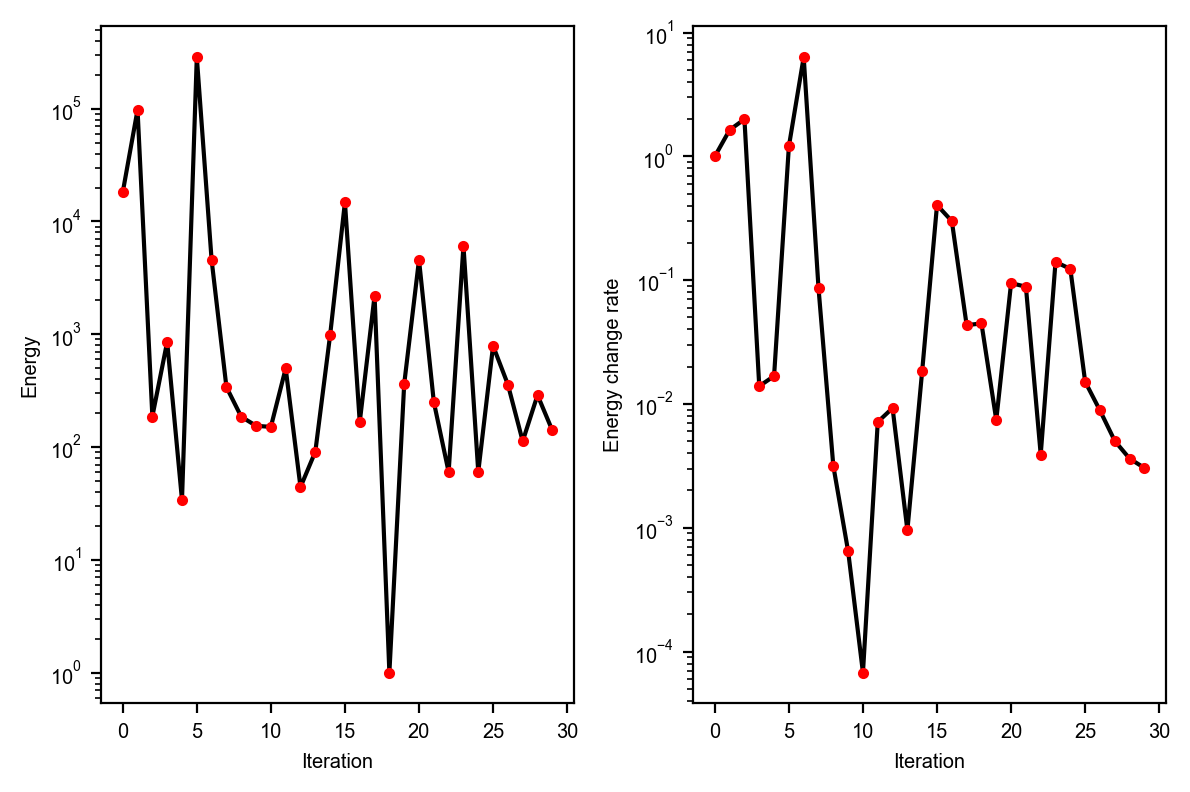

<Figure size 600x400 with 0 Axes>

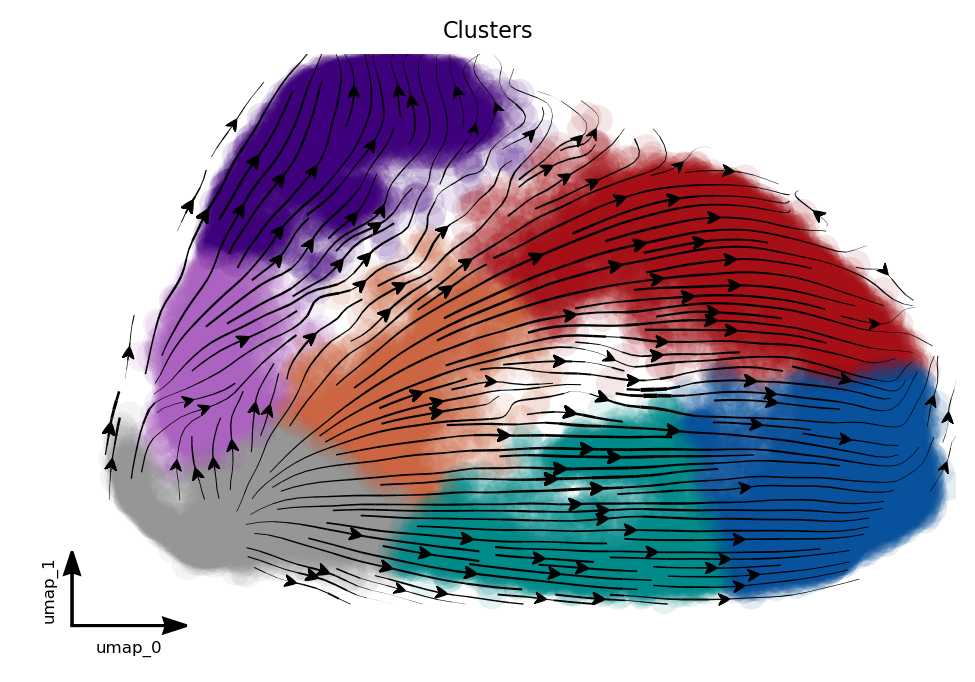

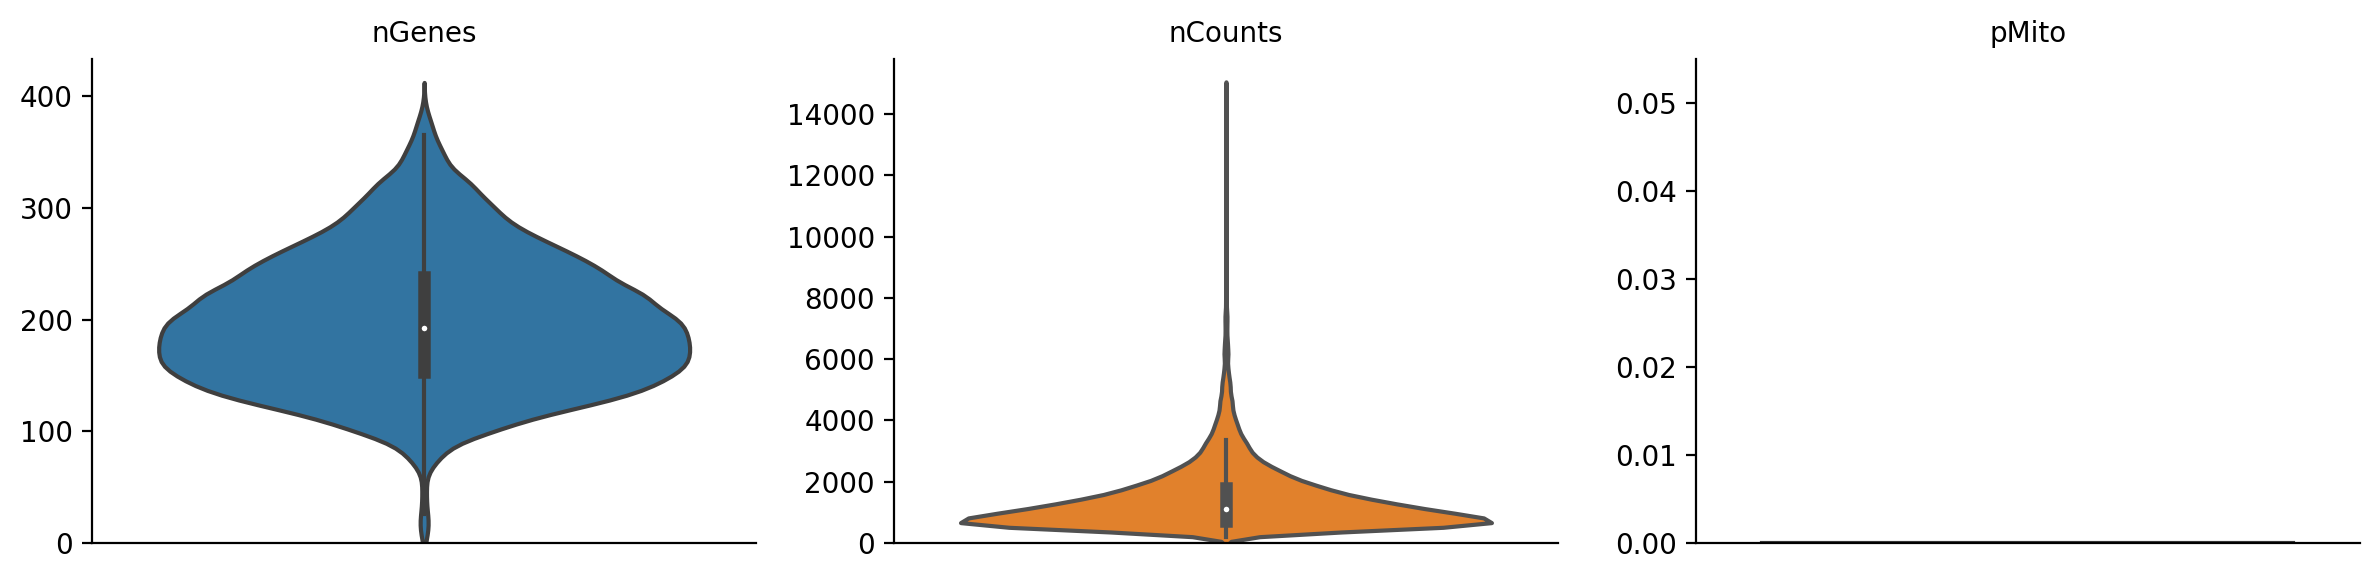

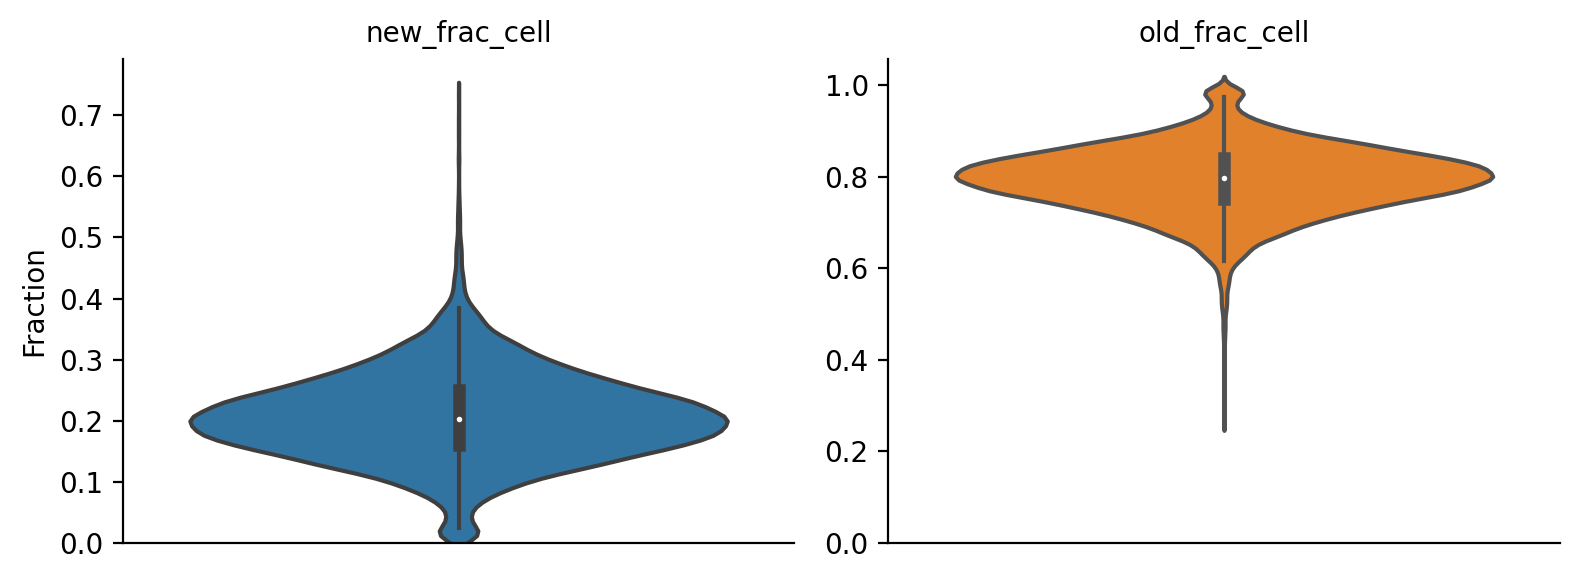

In [11]:
# Run without specifying experiment type
adata_test1 = create_adata(full_RNA_folder, new_RNA_folder, gene_mod)
dynamo_workflow(adata_test1, spec_expt=False)
dynamo_vis(adata_test1, color_group = 'Clusters', cluster_colors = cluster_colors)

## Test out differential geometry pipeline
Calculate RNA acceleration

In [14]:
dyn.tl.cell_velocities(adata_test1, basis='pca')

projecting velocity vector to low dimensional embedding...:   1%|▏         | 235/17000 [00:00<00:07, 2340.24it/s]

Using existing pearson_transition_matrix found in .obsp.


projecting velocity vector to low dimensional embedding...: 100%|██████████| 17000/17000 [00:09<00:00, 1742.98it/s]


AnnData object with n_obs × n_vars = 17000 × 429
    obs: 'sample', 'RT_group', 'umap_Tcell_5k_aligned_1', 'umap_Tcell_5k_aligned_2', 'umap_Tcell_all_5k_aligned_1', 'umap_Tcell_all_5k_aligned_2', 'Tcell_5k_aligned_cluster', 'Tcell_5k_aligned_6clust', 'Tcell_5k_aligned_7clust', 'label_time', 'Clusters', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap'
    var: 'gene_id', 'gene_type', 'exon_intron', 'gene_short_name', 'index', 'total_count', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'f

In [15]:
dyn.vf.VectorField(adata_test1,
                   basis='pca')

AnnData object with n_obs × n_vars = 17000 × 429
    obs: 'sample', 'RT_group', 'umap_Tcell_5k_aligned_1', 'umap_Tcell_5k_aligned_2', 'umap_Tcell_all_5k_aligned_1', 'umap_Tcell_all_5k_aligned_2', 'Tcell_5k_aligned_cluster', 'Tcell_5k_aligned_6clust', 'Tcell_5k_aligned_7clust', 'label_time', 'Clusters', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca'
    var: 'gene_id', 'gene_type', 'exon_intron', 'gene_short_name', 'index', 'total_count', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    

In [16]:
dyn.vf.rank_velocity_genes(adata_test1,
                           groups='Clusters', 
                          vkey='velocity_N'); # tutorial uses velocity_S, but adata only has velocity_N and velocity_T in layers


In [17]:
rank_speed = adata_test1.uns['rank_velocity_N'];
rank_abs_speed = adata_test1.uns['rank_abs_velocity_N'];

In [39]:
# save streamline plot
figure_name = "Tcell_newRNA_Tcell-mod-genes_20221004_noclusters"
dyn.pl.streamline_plot(adata_test1,color='Clusters', color_key = cluster_colors, show_legend=False, ncols=3, dpi=300, save_show_or_return='return')
# dyn.pl.streamline_plot(adata_test1, show_legend=False, ncols=3, dpi=300, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)

Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/Tcell_newRNA_Tcell-mod-genes_20221004_noclusters.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [51]:
plt.rcParams.update({'font.size': 18, 
                    })

In [52]:
figure_name = "Egr1_vel_nostream"
dyn.pl.umap(adata_test1, color=['EGR1'], layer='velocity_N', frontier=False, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)

Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/Egr1_vel_nostream.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [53]:

figure_name = "Tcf7_vel_nostream"
dyn.pl.umap(adata_test1, color=['TCF7'], layer='velocity_N', frontier=False, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)
#dyn.pl.umap(adata_test1, color=['TCF7'], layer='acceleration', frontier=True)

Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/Tcf7_vel_nostream.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [54]:
figure_name = "Myc_vel_nostream"
dyn.pl.umap(adata_test1, color=['MYC'], layer='velocity_N', frontier=False, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)


Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/Myc_vel_nostream.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [55]:
figure_name = "Tbx21_vel_nostream"
dyn.pl.umap(adata_test1, color=['TBX21'], layer='velocity_N', frontier=False, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)
#dyn.pl.umap(adata_test1, color=['TBX21'], layer='acceleration', frontier=True)

Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/Tbx21_vel_nostream.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [56]:
figure_name = "Runx2_vel"
dyn.pl.umap(adata_test1, color=['RUNX2'], layer='velocity_N', frontier=True, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)


Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/Runx2_vel.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [57]:
figure_name = "Zeb2_vel"
dyn.pl.umap(adata_test1, color=['ZEB2'], layer='velocity_N', frontier=True, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)


Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/Zeb2_vel.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [58]:
figure_name = "Stat3_vel"
dyn.pl.umap(adata_test1, color=['STAT3'], layer='velocity_N', frontier=True, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)


Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/Stat3_vel.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [56]:
figure_name = "Mxi1_vel"
dyn.pl.umap(adata_test1, color=['MXI1'], layer='velocity_N', frontier=True, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)


Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/Mxi1_vel.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [59]:
figure_name = "Eomes_vel_nostream"
dyn.pl.umap(adata_test1, color=['EOMES'], layer='velocity_N', frontier=False, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)


Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/Eomes_vel_nostream.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [58]:
figure_name = "Myb_vel"
dyn.pl.umap(adata_test1, color=['MYB'], layer='velocity_N', frontier=True, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)


Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/Myb_vel.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [59]:
figure_name = "Stat5a_vel"
dyn.pl.umap(adata_test1, color=['STAT5A'], layer='velocity_N', frontier=True, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)


Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/Stat5a_vel.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [60]:
figure_name = "BHLHE40_vel"
dyn.pl.umap(adata_test1, color=['BHLHE40'], layer='velocity_N', frontier=True, save_show_or_return='return')
dyn.pl.save_fig(path=output_folder_new+ figure_name, prefix=None, dpi=None, ext='pdf', transparent=True, close=True, verbose=True)
#dyn.pl.umap(adata_test1, color=['BHLHE40'], layer='acceleration', frontier=True)

Saving figure to /Users/kathleenabadie/Google Drive/1.Lab_starting_March_2018/5.Experiments_labwork/RNAseq/sci-FATE-seq/2019.06.11_scifate_expt1/202108_output/BHLHE40_vel.pdf...
Done


<Figure size 600x400 with 0 Axes>

In [ ]:
dyn.pl.umap(adata_test1, color=['MYB'], layer='velocity_N', frontier=True)
dyn.pl.umap(adata_test1, color=['MYB'], layer='acceleration', frontier=True)

In [ ]:
dyn.pl.umap(adata_test1, color=['EGR1'], layer='velocity_N', frontier=True)
dyn.pl.umap(adata_test1, color=['EGR1'], layer='acceleration', frontier=True)